In [ ]:
%%bash
pip install -q bigframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
%load_ext google.cloud.bigquery

In [ ]:
import bigframes.pandas as bpd

PROJECT_ID = "<compute-project-id>"  # @param {type:"string"}
REGION = "EU"  # @param {type:"string"}
MAX_ROWS = 20000000

# Set BigQuery DataFrames options
# Note: The project option is not required in all environments.
# On BigQuery Studio, the project ID is automatically detected.
bpd.options.bigquery.project = PROJECT_ID

# Note: The location option is not required.
# It defaults to the location of the first table or query
# passed to read_gbq(). For APIs where a location can't be
# auto-detected, the location defaults to the "US" location.
bpd.options.bigquery.location = REGION

In [ ]:
# Importing the matplotlib library
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
params = {
    "max_rows": MAX_ROWS
}

# Scenario 1: Analyze peak usage hours: Compare 3 different mechanisms

## Pandas DataFrame

In [ ]:
%%time
%%bigquery cycle_hire_df --params $params --project $PROJECT_ID
SELECT
  *
FROM
    `bigquery-public-data`.london_bicycles.cycle_hire
LIMIT @max_rows

Query is running:   0%|          |

Downloading:   0%|          |

CPU times: user 19.4 s, sys: 15.7 s, total: 35 s
Wall time: 40.6 s


CPU times: user 1.62 s, sys: 1.01 s, total: 2.63 s
Wall time: 2.11 s


Text(0.5, 1.0, 'Number of Bicycle Hires by Hour of the Day')

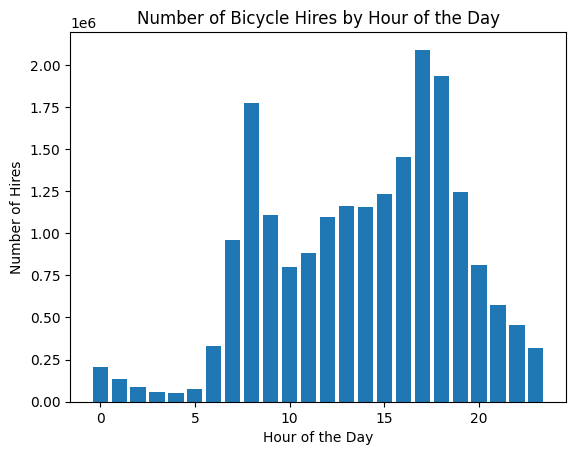

In [ ]:
%%time
cycle_hire_df['start_hour'] = cycle_hire_df['start_date'].dt.hour

hourly_hires = cycle_hire_df.groupby('start_hour').size()

plt.bar(hourly_hires.index, hourly_hires.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Hires')
plt.title('Number of Bicycle Hires by Hour of the Day')

## Bigquery DataFrame

In [ ]:
%%time
# Create a BigFrame from the cycle_hire table
cycle_hire_bf = bpd.read_gbq(
    "bigquery-public-data.london_bicycles.cycle_hire", max_results=MAX_ROWS, use_cache=False
)

CPU times: user 350 ms, sys: 60.3 ms, total: 410 ms
Wall time: 35.7 s


CPU times: user 1.02 s, sys: 31.5 ms, total: 1.05 s
Wall time: 18.7 s


Text(0.5, 1.0, 'Number of Bicycle Hires by Hour of the Day')

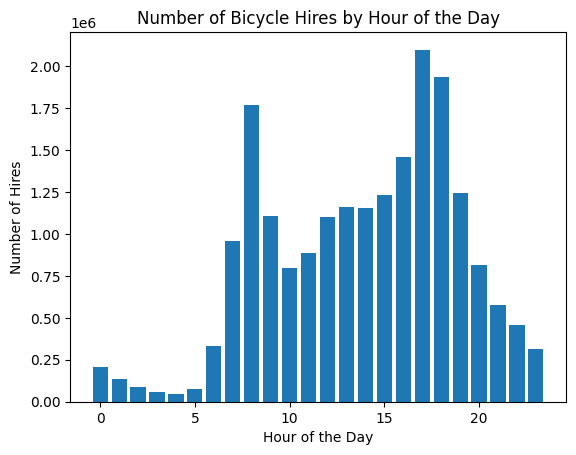

In [ ]:
%%time
cycle_hire_bf['start_hour'] = cycle_hire_bf['start_date'].dt.hour

hourly_hires = cycle_hire_bf.groupby('start_hour').size()

plt.bar(hourly_hires.index, hourly_hires.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Hires')
plt.title('Number of Bicycle Hires by Hour of the Day')

## Query in BigQuery

In [ ]:
%%time
%%bigquery peak_time --project $PROJECT_ID
SELECT
  EXTRACT(HOUR FROM start_date) AS start_hour,
  COUNT(*) AS num_hires
FROM
    `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY 1
ORDER BY 1 ASC

Query is running:   0%|          |

Downloading:   0%|          |

CPU times: user 95.8 ms, sys: 10.9 ms, total: 107 ms
Wall time: 2.21 s


CPU times: user 51.9 ms, sys: 2.03 ms, total: 53.9 ms
Wall time: 53.1 ms


Text(0.5, 1.0, 'Number of Bicycle Hires by Hour of the Day')

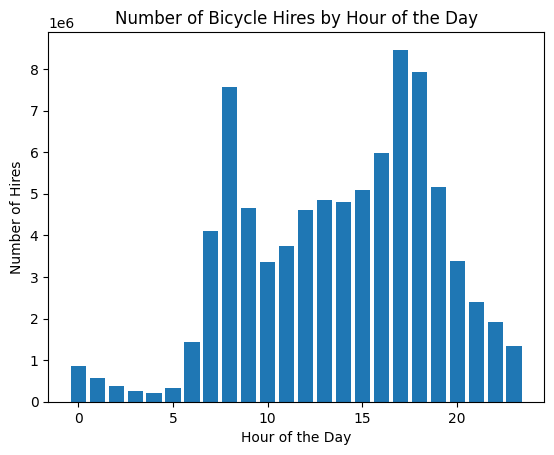

In [ ]:
%%time
plt.bar(peak_time.start_hour, peak_time.num_hires)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Hires')
plt.title('Number of Bicycle Hires by Hour of the Day')

# Get Most Popular Stations and Monthly Rental Trends

In [ ]:
%%time
# Create BigFrames from the tables
cycle_hire_bf = bpd.read_gbq("bigquery-public-data.london_bicycles.cycle_hire", use_cache=False)
cycle_stations_bf = bpd.read_gbq("bigquery-public-data.london_bicycles.cycle_stations", use_cache=False)

# Join the BigFrames on the start station name
joined_bf = cycle_hire_bf.merge(
    cycle_stations_bf, left_on="start_station_name", right_on="name", how="inner"
)

# Calculate the average duration of rentals for each station
average_duration_by_station = (
    joined_bf.groupby("start_station_name")["duration"].mean().sort_values(ascending=False)
)

# Display the top 10 stations with the longest average rental durations
print(average_duration_by_station.head(10))

# Analyze rental trends over time
# Extract the month and year from the start_date column
joined_bf["month"] = joined_bf["start_date"].dt.month
joined_bf["year"] = joined_bf["start_date"].dt.year

# Group by month and year, and count the number of rentals
monthly_rentals = joined_bf.groupby(["year", "month"]).size()

# Print the monthly rental trends
print(monthly_rentals)

start_station_name
Brandon Street, Walworth                      3551.333834
Burgess Park Albany Road, Walworth            3080.065032
South Bermondsey Station, Bermondsey          2903.396382
Saunders Ness Road, Cubitt Town               2618.056549
Black Lion Gate, Kensington Gardens           2602.048262
Stebondale Street, Cubitt Town                2571.521903
Saltoun Road, Brixton                         2564.568841
Park Lane , Hyde Park                         2513.752669
Putney Rail Station, Putney                   2503.171697
East Village, Queen Elizabeth Olympic Park     2491.97908
Name: duration, dtype: Float64


year  month
2015  1         475176
      2         471425
      3         603605
      4         715698
      5         820183
      6         953556
      7        1033440
      8         947615
      9         829382
      10        813385
      11        629487
      12        559455
2016  1         539084
      2         547857
      3         605856
      4         709101
      5         920837
      6         875515
      7        1080299
      8        1053682
      9         973548
      10        877453
      11        661205
      12        613038
2017  1         593152
dtype: Int64
CPU times: user 960 ms, sys: 38.6 ms, total: 999 ms
Wall time: 19.6 s


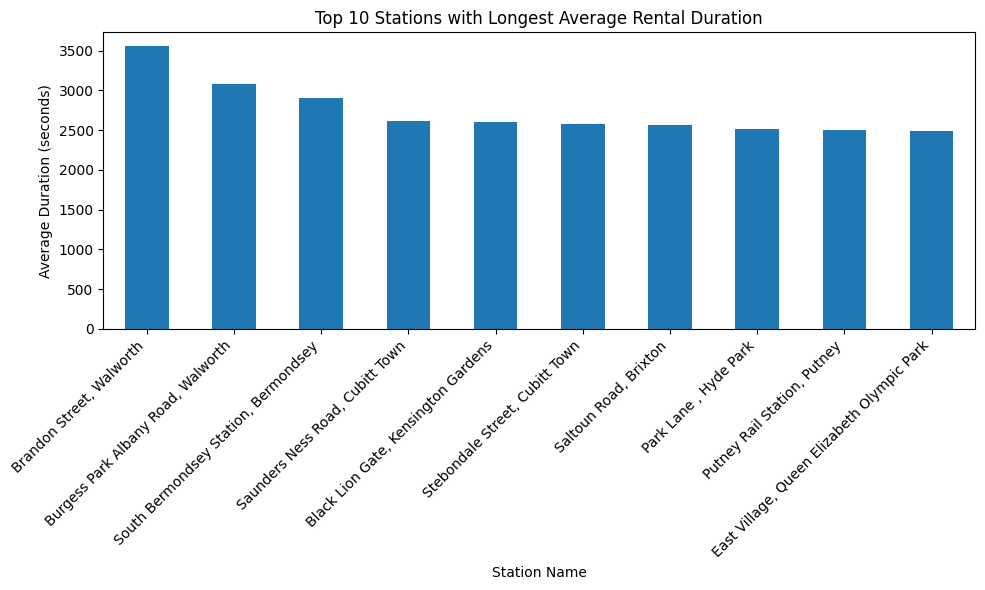

In [ ]:
# Convert to Pandas DataFrame
pd_df = average_duration_by_station.head(10).to_pandas()

# Plot using Pandas
plt.figure(figsize=(10, 6))
pd_df.plot(kind="bar")
plt.title("Top 10 Stations with Longest Average Rental Duration")
plt.xlabel("Station Name")
plt.ylabel("Average Duration (seconds)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

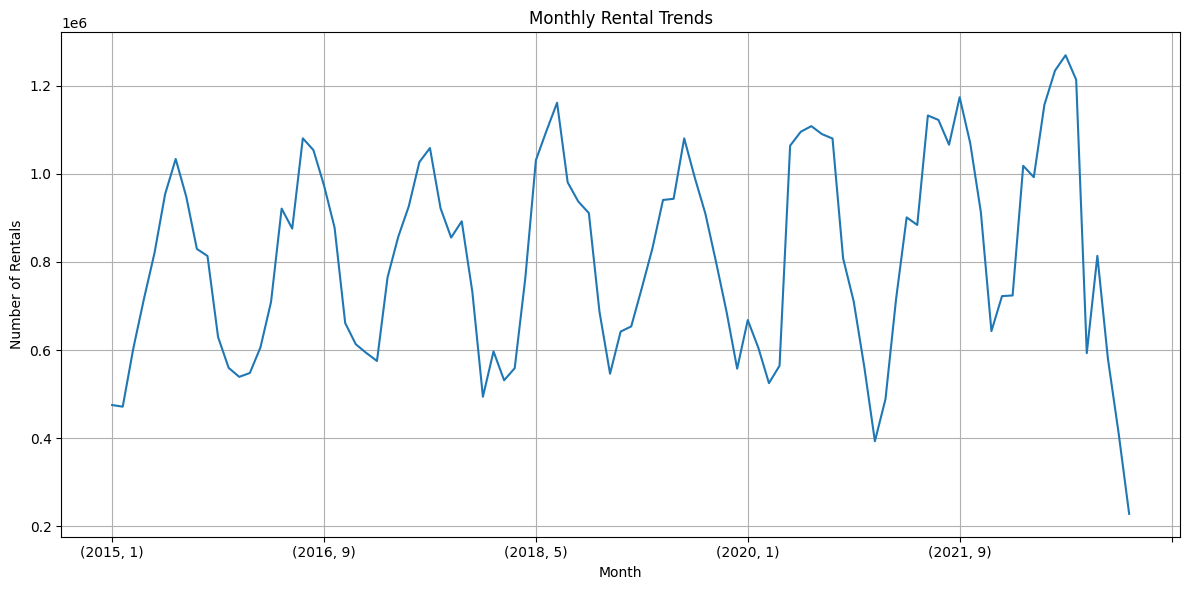

In [ ]:
# Convert the BigFrame to a Pandas Series
monthly_rentals_series = monthly_rentals.to_pandas()

# Plot the monthly rental trends
plt.figure(figsize=(12, 6))
monthly_rentals_series.plot()
plt.title("Monthly Rental Trends")
plt.xlabel("Month")
plt.ylabel("Number of Rentals")
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculate the average rental duration for each day of the week.

In [ ]:
%%time
# Create BigFrames from the tables
cycle_hire_bf = bpd.read_gbq("bigquery-public-data.london_bicycles.cycle_hire", use_cache=False)

NameError: name 'bpd' is not defined